# 실습 2 - 로지스틱 회귀와 회귀 트리

##### Logistic Regression

##### 2-0. 로지스틱 회귀 알고리즘이 참고하는 함수의 이름은?

A : 시그모이드

##### Data Load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

##### 2-1. StandardScaler를 이용해 스케일링을 진행하고 train, test 데이터셋을 분리해주세요.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler( )로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

# train, test 데이터셋 분리 test_size = 0.3, random_state = 0
X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)


##### 2-2. Logistic Regression을 이용해서 학습, 예측을 수행하는데 점수를 낼 때 roc_auc_score로 해서 predict의 점수 / predict_proba의 점수를 각각 내고 predict() 함수와 predict_proba() 함수의 차이를 써주세요.

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
lr_clf = LogisticRegression() 
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

# predict데이터, predict_proba데이터 각각에 대한 roc_auc_score 측정
print('roc_auc: {0:.3f}, roc_auc:{1:.3f}'.format(roc_auc_score(y_test, lr_preds),
                                                 roc_auc_score(y_test , lr_preds_proba)))

roc_auc: 0.972, roc_auc:0.995


- predict() 함수와 predict_proba() 함수의 차이는?\
A : predict() 함수는 0과 1의 배열로 값을 나타내지만 predict_proba() 함수는 확률을 사용해서 배열을 만든다.

---

##### 회귀 트리

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline

##### 2-3. 다음은 여러 광고 매체에 따른 매출액 데이터입니다.
##### 주어진 함수를 사용해서 DT, RF, GB, XGB 각각에 대한 평균 RMSE 값을 구해주세요.

In [5]:
# 여러 광고 매체들에 의한 매출액 증가 데이터
ad = pd.read_csv("Advertising.csv")
y_target = ad.Sales
X_data = ad[['TV', 'Radio', 'Newspaper']]

In [6]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

# 각각의 모델은 random_state = 0, n_estimators = 1000으로 합니다.
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg]
for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 1.549 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 0.791 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 0.757 
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 0.880 


##### 2-4. XGB 모델의 feature_importance를 시각화하고 중요도가 가장 낮은 변수가 뭔지 써주세요.


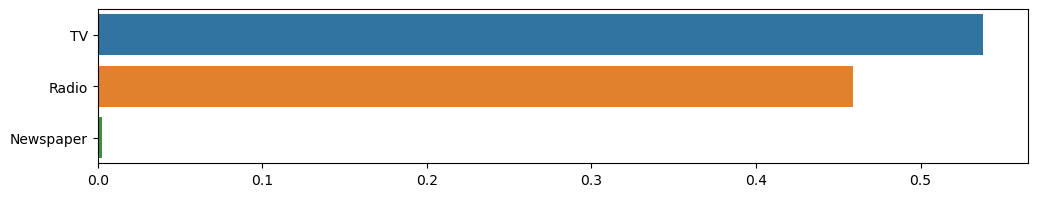

In [7]:
# XGB 모델 정의 n_estimators = 1000
xgb_reg = XGBRegressor(n_estimators=1000)

# X_data, y_target 데이터 셋을 적용하여 학습   
xgb_reg.fit(X_data, y_target)

feature_series = pd.Series(data=xgb_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
plt.figure(figsize=(12, 2))
sns.barplot(x= feature_series, y=feature_series.index)
plt.show()

- 가장 중요도가 낮은 변수는?\
A : Newspaper

##### 2-5. TV가 Sales에 미치는 영향을 알아보기 위해 LinearRegression, RandomForestRegressor의 두 모형을 사용하기로 함.
##### RandomForestRegressor()의 max_depth는 각각 3, 10으로 설정하고 테스트용 데이터를 0에서 300까지 설정해서 시각화해주세요.

In [8]:
ad_sample = ad[['TV','Sales']]
ad_sample = ad_sample.sample(n=100,random_state=0)

# 선형 회귀와 트리 기반의 Regressor 생성. RandomForestRegressor의 max_depth는 각각 3, 10
lr_reg = LinearRegression()
rf_reg3 = RandomForestRegressor(max_depth=3)
rf_reg10 = RandomForestRegressor(max_depth=10)

# 실제 예측을 적용할 테스트용 데이터 셋을 0 ~ 300 까지 100개 데이터 셋 생성. 
X_test = np.arange(0, 300, 0.04).reshape(-1, 1)

# ad 데이터에서 시각화를 위해 피처는 TV만, 그리고 결정 데이터인 Sales 추출
X_feature = ad_sample['TV'].values.reshape(-1,1)
y_target = ad_sample['Sales'].values.reshape(-1,1)

# 학습과 예측 수행. 
lr_reg.fit(X_feature, y_target)
rf_reg3.fit(X_feature, y_target)
rf_reg10.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf3 = rf_reg3.predict(X_test)
pred_rf10 = rf_reg10.predict(X_test)

C:\Users\82109\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\82109\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


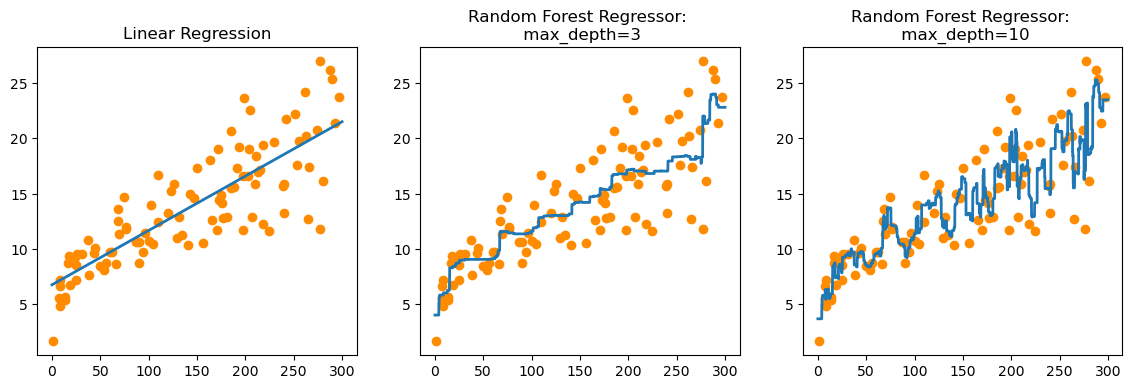

In [9]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 0 ~ 300으로 변환하며 입력했을 때, 선형 회귀와 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(ad_sample.TV , ad_sample.Sales,c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# RandomForestRegressor의 max_depth를 3로 했을 때 회귀 예측선 
ax2.set_title('Random Forest Regressor: \n max_depth=3')
ax2.scatter(ad_sample.TV , ad_sample.Sales,c="darkorange")
ax2.plot(X_test, pred_rf3, label="max_depth:3", linewidth=2 )

# RandomForestRegressor의 max_depth를 10로 했을 때 회귀 예측선 
ax3.set_title('Random Forest Regressor: \n max_depth=10')
ax3.scatter(ad_sample.TV , ad_sample.Sales,c="darkorange")
ax3.plot(X_test, pred_rf10, label="max_depth:10", linewidth=2)
plt.show()